In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

from torch.utils.data import DataLoader
from dataset.util import load_clustered_data, prepare_time_series
from dataset import SlidingWinDataset, ClusterDataset

from model import RTDLinear
from trainer import load_config

In [2]:
model = RTDLinear.Model(load_config('../log/cluster0/RTDLinear/2024-10-05-11-53/model_config.yml'))
model.load_state_dict(torch.load('../log/cluster0/RTDLinear/2024-10-05-11-53/checkpoints/epoch_328.pth'))

<All keys matched successfully>

In [3]:
df = load_clustered_data(
	cluster_info='../data/cluster_info/cluster_info_a_s.csv',
	processed_data='../data/processed/data.csv',
)
df

[              9012    9256    9200    9272    9060    9377    9048    9333  \
 2016-02-01     600   42100  271300  193600   69200  224900   18400   95800   
 2016-02-02  504000  405800  227900  179200  375400  277900  413600  152600   
 2016-02-03  467300  377800  136600  220300  231900  245100  336300  260400   
 2016-02-04  382200  325500   14300  130800  194300  311100  323900  340100   
 2016-02-05  298700  767800  487100  113700  194300  337900  229900  374200   
 ...            ...     ...     ...     ...     ...     ...     ...     ...   
 2018-01-27  215100   41800  350400  200100  199300  103700  222500   78300   
 2018-01-28  187800  152200  320700  182800  123700  201000  222800   30200   
 2018-01-29  163500   72800  298300  181600  382100  207300   52500  100100   
 2018-01-30  139000  167300  293500  197000  349200   84200   37900  107700   
 2018-01-31  138200  129900  217600  278500  299400   90700  101500   84300   
 
               9053    9045  ...    9409    9428  

In [4]:
prepare_time_series(df[0], '9012')[0]

,9012,DoW,DoM,DoY,WoY,MoY
0,600,-0.500000,-0.500000,5.020548,-0.423077,-0.409091
1,504000,-0.333333,-0.466667,5.020548,-0.423077,-0.409091
2,467300,-0.166667,-0.433333,5.020548,-0.423077,-0.409091
3,382200,0.000000,-0.400000,5.020548,-0.423077,-0.409091
4,298700,0.166667,-0.366667,5.020548,-0.423077,-0.409091
...,...,...,...,...,...,...
726,215100,0.333333,0.366667,5.026027,-0.442308,-0.500000
727,187800,0.500000,0.400000,5.026027,-0.442308,-0.500000
728,163500,-0.500000,0.433333,5.026027,-0.423077,-0.500000
729,139000,-0.333333,0.466667,5.026027,-0.423077,-0.500000


<Axes: >

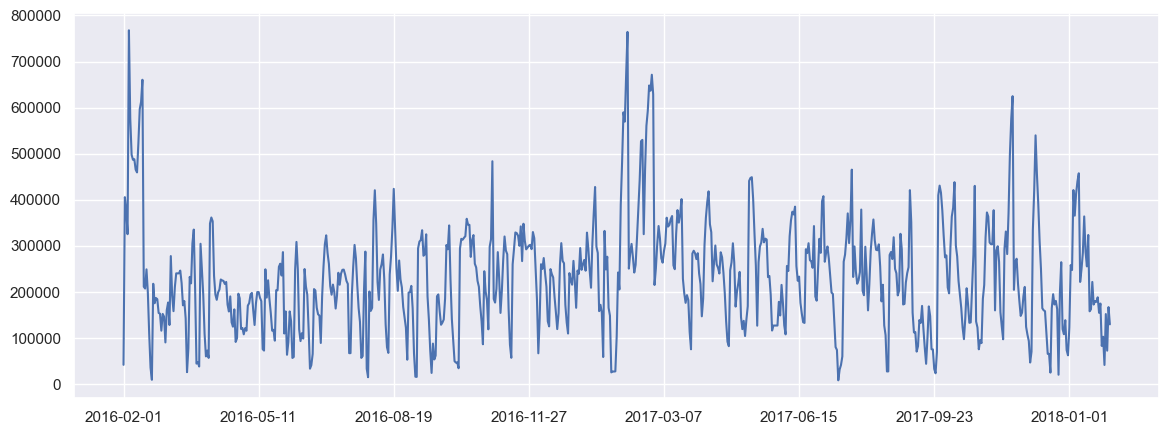

In [5]:
df[0]['9256'].plot(figsize=(14, 5))

In [6]:
ts = df[0]['9256'].reset_index().drop('index', axis=1).reset_index().rename(columns={'index': 'time_ticks'})
ts

,time_ticks,9256
0,0,42100
1,1,405800
2,2,377800
3,3,325500
4,4,767800
...,...,...
726,726,41800
727,727,152200
728,728,72800
729,729,167300


In [7]:
preds = []
start = 200
end = 600

with torch.no_grad():
	i = 0
	for y_win, X_win in DataLoader(SlidingWinDataset(ts, sliding_win=20), shuffle=False):
		if start <= i < end:
			y = y_win[..., 1:]
			preds.append(model(X_win).item())
		i += 1

In [8]:
y.shape

torch.Size([1, 1])

In [9]:
preds

[296198.4375,
 276143.15625,
 277813.09375,
 238718.9375,
 228017.8125,
 334051.6875,
 183956.796875,
 148149.84375,
 89479.5859375,
 34813.109375,
 87298.0078125,
 87967.53125,
 125086.625,
 186306.640625,
 178947.59375,
 142928.015625,
 126051.796875,
 126979.828125,
 158003.796875,
 183087.15625,
 276809.625,
 256928.15625,
 288457.0625,
 214361.625,
 134504.09375,
 103511.1796875,
 102520.7421875,
 63022.125,
 65961.0390625,
 46189.0546875,
 250184.15625,
 273694.75,
 275679.3125,
 289436.0,
 277481.59375,
 312156.875,
 304497.375,
 294427.3125,
 247901.34375,
 283651.78125,
 290284.84375,
 253341.15625,
 233185.546875,
 255238.5,
 197413.390625,
 169816.46875,
 150686.3125,
 111712.21875,
 248272.71875,
 208809.234375,
 207175.78125,
 136806.875,
 299113.625,
 288597.96875,
 437326.25,
 183510.125,
 185579.71875,
 192966.109375,
 284336.21875,
 223141.5,
 188348.921875,
 201667.984375,
 241677.5625,
 293121.125,
 258180.703125,
 286132.90625,
 150451.4375,
 149998.34375,
 52007.96

<Axes: >

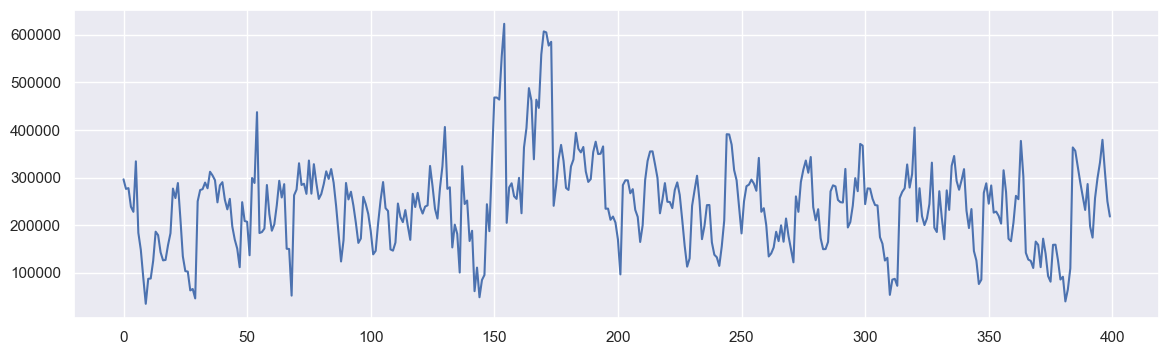

In [10]:
pd.Series(preds).plot(figsize=(14, 4))

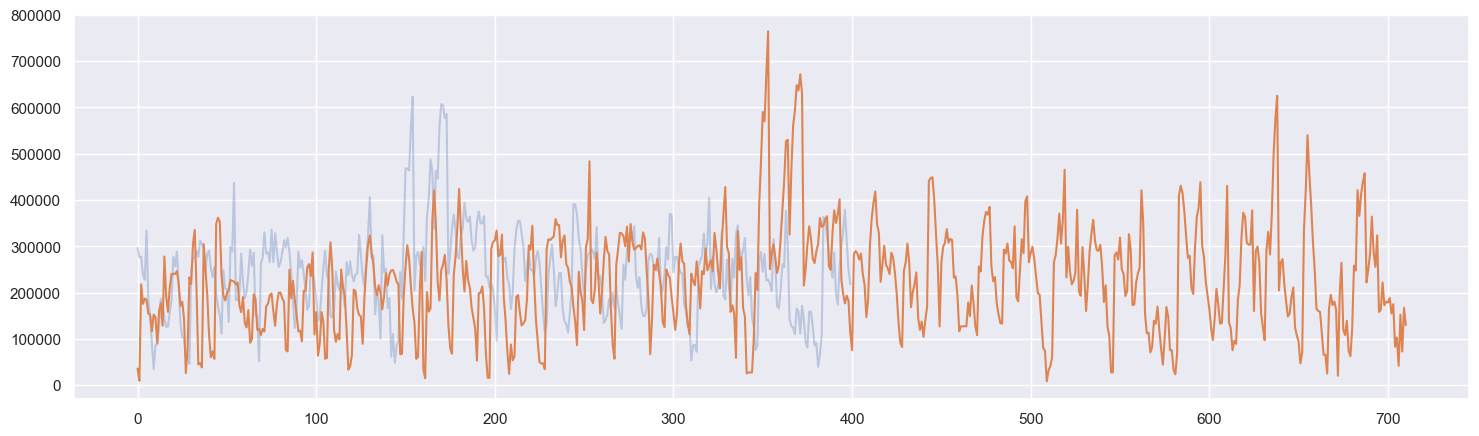

In [11]:
target_ts = ts['9256'].iloc[20:].reset_index(drop=True)
pred_ts = pd.Series(preds)
mae = abs( - pred_ts)


plt.figure(figsize=(18, 5))
plt.plot(pd.Series(preds)[: ], alpha=0.3)
plt.plot(target_ts[: ])
# plt.plot(target_ts[mae > theta], 'o', color='r')

<Axes: >

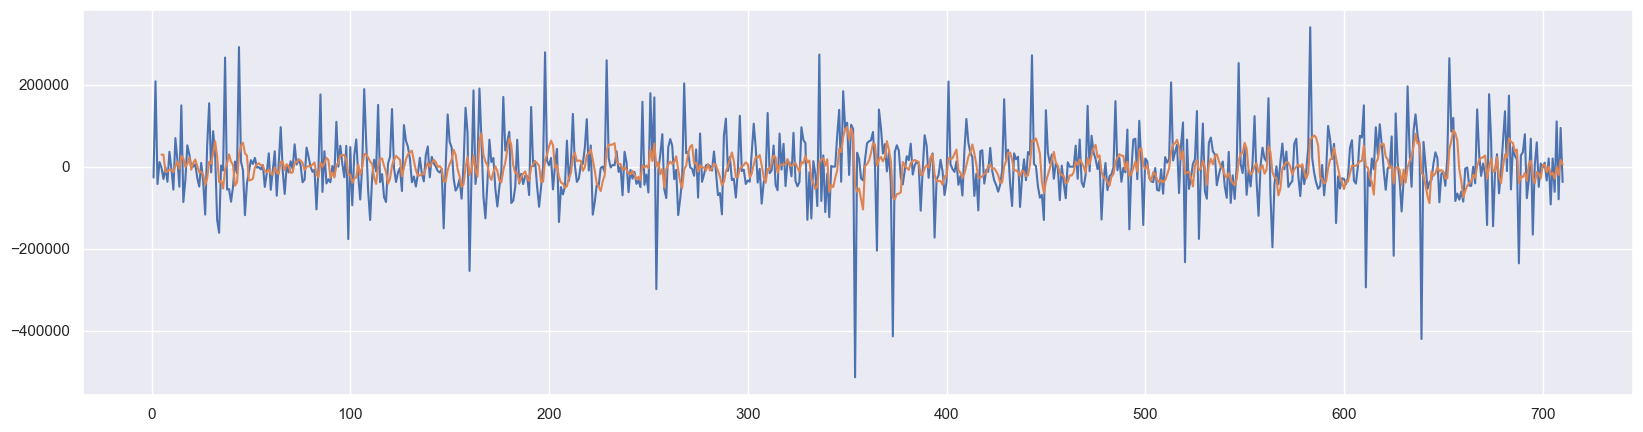

In [45]:
target_ts.diff(1).dropna().plot(figsize=(20, 5))
target_ts.diff(1).dropna().rolling(5).mean().plot(figsize=(20, 5))

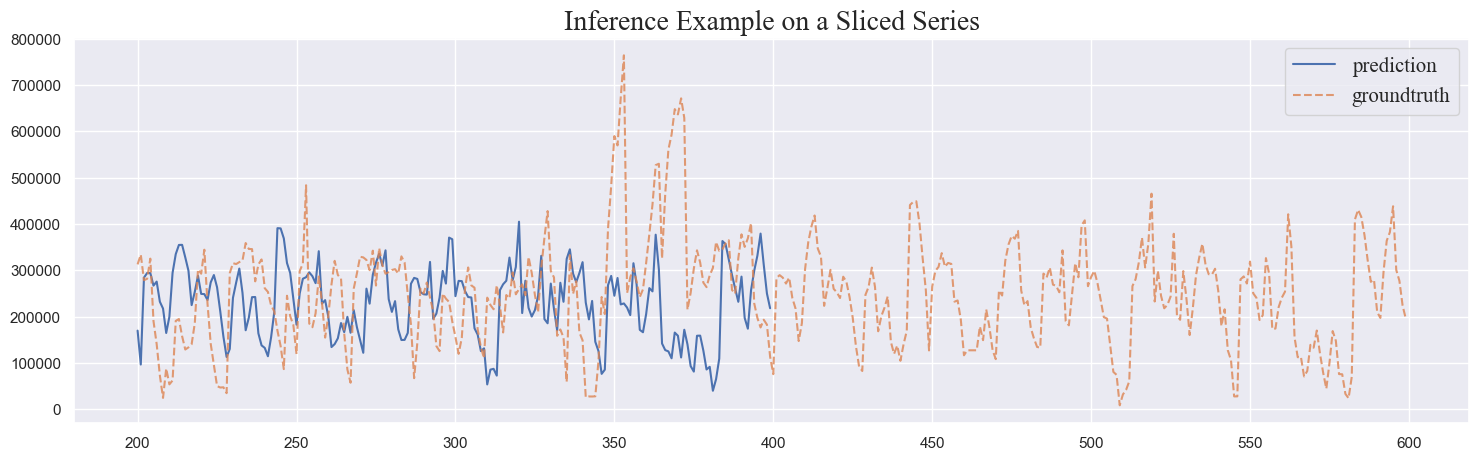

In [12]:
plt.figure(figsize=(18, 5))
start = 200
end = 600

plt.title('Inference Example on a Sliced Series', fontfamily='Times New Roman', fontsize=20)
plt.plot(pd.Series(preds)[start: end], label='prediction')
plt.plot(target_ts[start: end], alpha=0.8, linestyle='--', label='groundtruth')
plt.legend(prop={'family': 'Times New Roman', 'size': 15})

In [13]:
model.td_linear

TDLinear(
  (moving_avg): SimpleMovingAverage(
    (moving_avg): AvgPool1d(kernel_size=(20,), stride=(1,), padding=(0,))
  )
  (t2v): Time2Vec()
)

In [14]:
len(preds), len(target_ts)

(400, 711)

<Axes: >

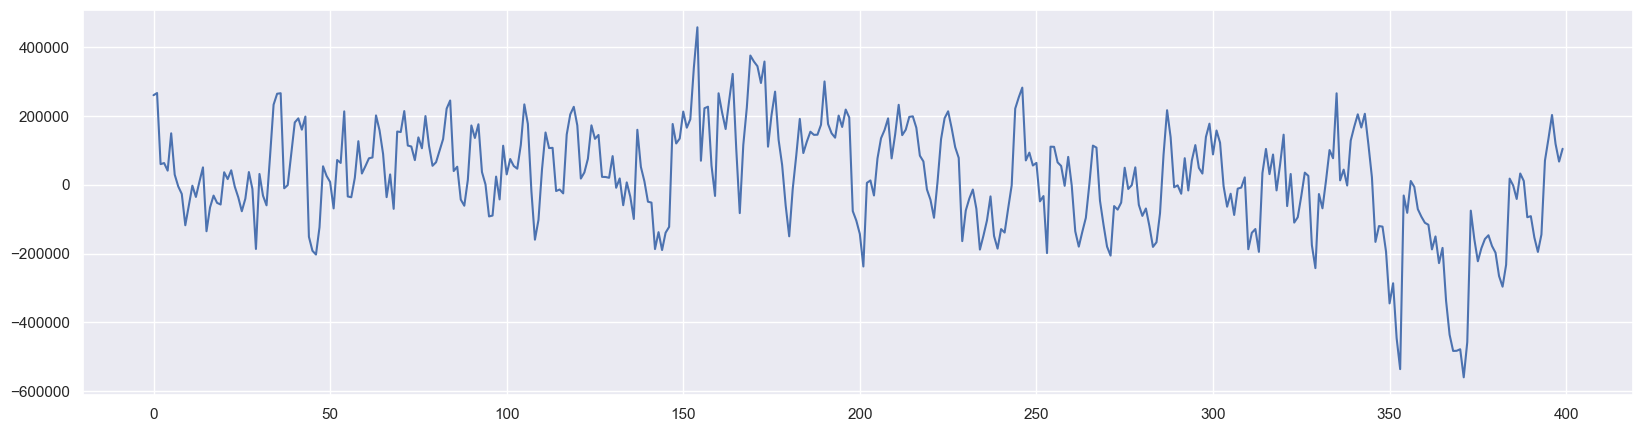

In [15]:
(pd.Series(preds) - target_ts).plot(figsize=(20, 5))